# 1. Uniform distribution

a) $$p(x_1, \dots, x_n | a) = \prod_{i=1}^n p(x_i | a) = \prod_{i=1}^n \frac{1}{a} = \frac{1}{a^n} \quad \text{for } 0 \leq x_i \leq a$$

b) MLE for $a$ maximizes the likelihood function w.r.t.$a$. Since $p(x_1, \dots, x_n | a)$ is maximized when $a$ is as small as possible while still being larger than all $x_i$, the MLE is: $\hat{a}_{\text{MLE}} = \max(x_1, x_2, \dots, x_n)$

It's biased.

$p(b) = \frac{b^{n-1}}{(a-b)^n} \quad \text{for } 0 < b < a$

$p(x < b) = \frac{b}{a}, \quad p(x \geq b) = 1 - p(x < b) = \frac{a - b}{a}$

$p(b) = \left( \frac{b^{n-1}}{a^n} \right) \cdot n = n \cdot \frac{b^{n-1}}{a^n} \cdot \frac{(a - b)^n}{a^n}$

$E = \int_0^a b \cdot p(b) \, db$

$E = \int_0^a b \cdot \frac{b^{n-1}}{(a-b)^n} \, db = \int_0^a \frac{b^n}{(a-b)^n} \, db$

$E = \frac{n}{n + 1} \cdot a$

$|E - a| = \left| \frac{n}{n + 1} a - a \right| = \left| -\frac{a}{n + 1} \right| = \frac{a}{n + 1}$



In [19]:
data = [0.5, 2.9, 4.1, 1.7]
n = len(data)
parameters = [(1, 1), (10, 1), (1, 10), (10, 10)]
for alpha, beta in parameters:
    map_a = max(beta, max(data))
    pm_a = ((n + alpha) / (n + alpha - 1)) * map_a
    print(f"alpha = {alpha}, beta = {beta}, MAP a = {map_a}, PM a = {pm_a}")

alpha = 1, beta = 1, MAP a = 4.1, PM a = 5.125
alpha = 10, beta = 1, MAP a = 4.1, PM a = 4.415384615384615
alpha = 1, beta = 10, MAP a = 10, PM a = 12.5
alpha = 10, beta = 10, MAP a = 10, PM a = 10.769230769230768


# 3. Semi-Practical: asymmetry of K

Optimal mu_q_p: -4.9917504768226015
Optimal sigma_q_p: 2.0145042297979483
Optimalmu_p_q: -3.000003394939598
Optimal sigma_p_q: 4.404546455078655


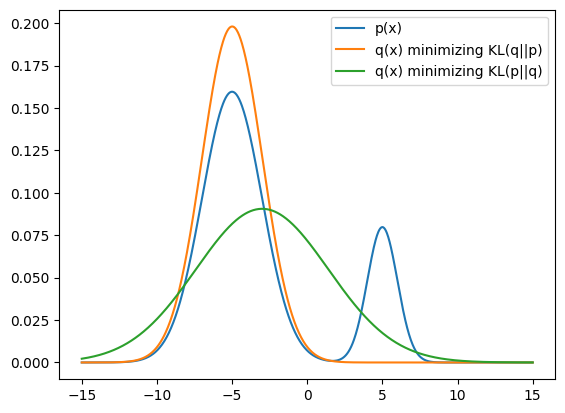

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def p(x):
    return 0.2 * norm.pdf(x, loc=5, scale=1) + 0.8 * norm.pdf(x, loc=-5, scale=2)

def q(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

def kl_q_p(mu, sigma):
    q_vals = q(x, mu, sigma)
    p_vals = p(x)
    return np.sum(q_vals * (np.log(q_vals + 1e-10) - np.log(p_vals + 1e-10))) * (x[1] - x[0])

def kl_p_q(mu, sigma):
    q_vals = q(x, mu, sigma)
    p_vals = p(x)
    return np.sum(p_vals * (np.log(p_vals + 1e-10) - np.log(q_vals + 1e-10))) * (x[1] - x[0])


x = np.linspace(-15, 15, 1000)

result_q_p = minimize(lambda params: kl_q_p(*params), [0, 1], bounds=[(-10, 10), (0.1, 10)])
mu_q_p, sigma_q_p = result_q_p.x

result_p_q = minimize(lambda params: kl_p_q(*params), [0, 1], bounds=[(-10, 10), (0.1, 10)])
mu_p_q, sigma_p_q = result_p_q.x

print("Optimal mu_q_p:", mu_q_p)
print("Optimal sigma_q_p:", sigma_q_p)
print("Optimalmu_p_q:", mu_p_q)
print("Optimal sigma_p_q:", sigma_p_q)

plt.plot(x, p(x), label="p(x)")
plt.plot(x, q(x, mu_q_p, sigma_q_p), label="q(x) minimizing KL(q||p)")
plt.plot(x, q(x, mu_p_q, sigma_p_q), label="q(x) minimizing KL(p||q)")
plt.legend()
plt.show()

When minimizing $KL(p||q)$, $q$ spreads to cover all regions where $p$ has probability mass, including low-probability areas. Minimizing $KL(q||p)$ focuses $q$ on the high-probability regions of $p$, ignoring the tails, leading to a more concentrated $q$.

# 4. Practical – Gaussian Process Regression

In [ ]:
! pip install GPy

In [3]:
import GPy

def train_gp(X, Y):
    kernel = GPy.kern.RBF(input_dim=X.shape[1], variance=1, lengthscale=1)
    model = GPy.models.GPRegression(X, Y, kernel)
    model.Gaussian_noise.variance = 0.1
    return model

In [ ]:
! wget https://cvml.ist.ac.at/courses/ModernML_F24/GPdata.txt .

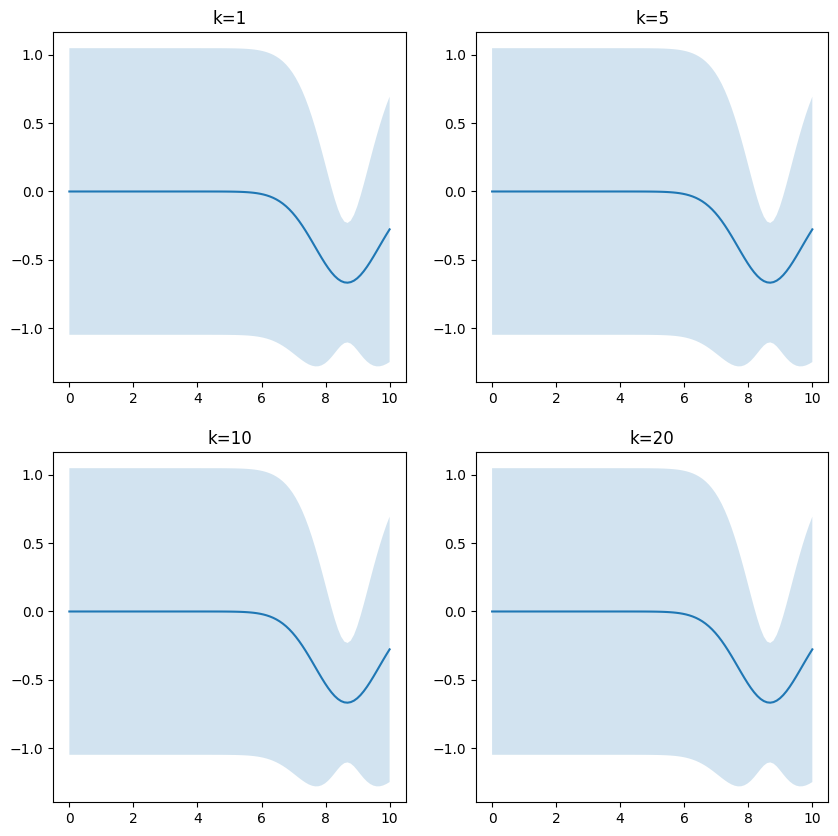

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = np.loadtxt('GPdata.txt')
X = data[:, 0].reshape(-1, 1)
Y = data[:, 1].reshape(-1, 1)

fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax = ax.flatten()
for i,k in enumerate([1, 5, 10, 20]):
    X = X[:k]
    Y = Y[:k]
    model = train_gp(X, Y)
    X_new = np.linspace(0, 10, 100).reshape(-1, 1)
    Y_new, Y_var = model.predict(X_new)
    ax[i].plot(X_new, Y_new)
    ax[i].fill_between(X_new.flatten(), Y_new.flatten() - np.sqrt(Y_var.flatten()), Y_new.flatten() + np.sqrt(Y_var.flatten()), alpha=0.2)
    ax[i].set_title(f'k={k}')
    

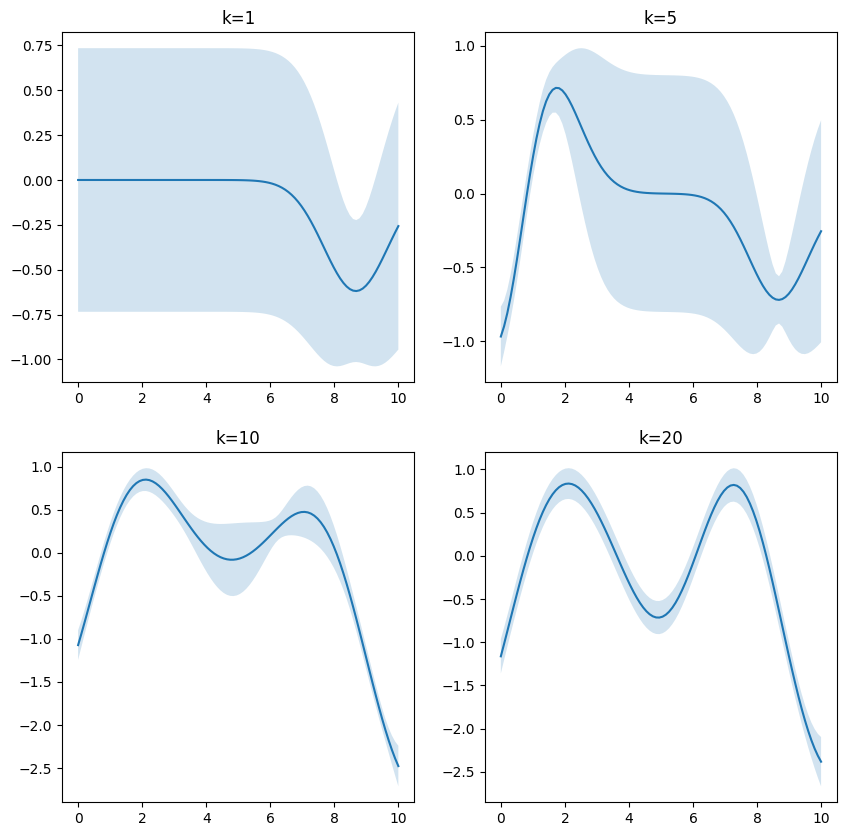

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax = ax.flatten()

for i,k in enumerate([1, 5, 10, 20]):
    X = data[:k, 0].reshape(-1, 1)
    Y = data[:k, 1].reshape(-1, 1)
    model = train_gp(X, Y)
    model.optimize()
    X_new = np.linspace(0, 10, 100).reshape(-1, 1)
    Y_new, Y_var = model.predict(X_new)
    ax[i].plot(X_new, Y_new)
    ax[i].fill_between(X_new.flatten(), Y_new.flatten() - np.sqrt(Y_var.flatten()), Y_new.flatten() + np.sqrt(Y_var.flatten()), alpha=0.2)
    ax[i].set_title(f'k={k}')